To make it work you need to install `skmixed` (use branch `categorical`)

https://github.com/aksholokhov/skmixed/tree/categorical

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

import pandas as pd
from pathlib import Path
from numpy.linalg import lstsq
import json

from skmixed.lme.models import LinearLMESparseModel
from skmixed.lme.problems import LinearLMEProblem
from skmixed.lme.oracles import LinearLMEOracle

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset_generator_directory = Path("/Users/aksh/Storage/repos/multilevel-model")
dataset = "simulation-2"
dataset_path = dataset_generator_directory / dataset / (dataset + ".csv") 
hierarchy_path = dataset_generator_directory / "hierarchy.csv"
true_coefficients_path = dataset_generator_directory / dataset / "KEY" / ("PARAMS-" + dataset + ".csv")
true_answers_path = dataset_generator_directory / dataset / "KEY" / ("TRUTH-" + dataset + ".csv")
true_parameters_path = dataset_generator_directory / dataset / ("SETTINGS-" + dataset + ".json")

data = pd.read_csv(dataset_path)
hierarchy = pd.read_csv(hierarchy_path)
hierarchy = hierarchy[hierarchy.location_id.isin(data.location_id.unique())]
hierarchy = hierarchy[['location_name', 'location_id', 'parent_id', 'level']].reset_index(drop=True)

data = data.merge(hierarchy, on="location_id", how="left")

levels = sorted(data["level"].unique())

covariates_colnames = [column for column in  data.columns if column.startswith("x_")]
target_colname = ["observation"]

num_fixed_effects = len(covariates_colnames)+1

data["intercept"] = 1
data["predictions"] = 0
data["residues"] = 0
data["se"] = 0
hierarchy["se"] = 1

## Separate LMM for each level

In [4]:
gammas = {}
sigmas = {}
betas = {}

current_level = data["level"] >= 0
level0_data = data[current_level][["intercept"] + covariates_colnames].to_numpy()
level0_target = data[current_level]["observation"].to_numpy()
level0_coefficients = lstsq(level0_data, level0_target, rcond=None)[0]
data.loc[current_level, "predictions"] = level0_data.dot(level0_coefficients)
data.loc[current_level, "residues"] = data.loc[current_level, "observation"] - data.loc[current_level, "predictions"]
current_se = np.sqrt((data.loc[current_level, "residues"].var()))
betas[0] = level0_coefficients
sigmas[0] = current_se

answers = [{**{
    "location_id": 1,
    "level": 0, 
    "intercept": level0_coefficients[0],
    "group_size": len(level0_data)
}, **{f"effect_{i-1}": level0_coefficients[i] for i in range(1, len(covariates_colnames)+1)} }]

In [5]:
for level in sorted(data["level"].unique())[1:]:
    current_level = data["level"] == level
    data.loc[current_level, "se"] = current_se
    X = data[current_level][covariates_colnames + [ "location_id", "se"]].to_numpy()
    column_labels = [1]*len(covariates_colnames) + [0, 4]
    X = np.vstack([column_labels, X])
    y = data[current_level]["observation"].to_numpy()
    model = LinearLMESparseModel(lb=0,
                                 lg=0, 
                                 nnz_tbeta=len(covariates_colnames)+1, 
                                 nnz_tgamma=1,
                                 tol=1e-7)
    problem = LinearLMEProblem.from_x_y(X, y, random_intercept=True)
    model.fit_problem(problem, initial_parameters={"beta": betas[level-1], "tbeta": betas[level-1]})
    
    oracle = LinearLMEOracle(problem)
    current_se = oracle.optimal_obs_std(**model.coef_)
    
        
    betas[level] = model.coef_["beta"]
    gammas[level] = model.coef_["gamma"]/(level+1)
    sigmas[level] = current_se
    
    data.loc[current_level, "se"] = current_se
    
    
    answers += [{**{
        "location_id": group,
        "intercept": x[0],
        "level": level,
        "group_size": size,
        } , **{
        f"effect_{i-1}": x[i] for i in range(1, len(covariates_colnames)+1)
        }} for group, size, x in zip(problem.group_labels,
                                     problem.groups_sizes,
                                     model.coef_["per_group_coefficients"][:, :-2])]

In [6]:
coefficients = pd.DataFrame(answers)
true_coefficients = pd.read_csv(true_coefficients_path)
coefficients = coefficients.merge(true_coefficients, on="location_id", how="inner", suffixes=('_pred', '_true'))
with open(true_parameters_path) as f:
    true_parameters = json.load(f)
coefficients["effect_0_pred"] = level0_coefficients[1]

In [7]:
coefficients[["location_id", "level", "intercept_true", "intercept_pred", "effect_0_true", "effect_0_pred"]]

,location_id,level,intercept_true,intercept_pred,effect_0_true,effect_0_pred
0,1.0,0,4.318642,4.065476,-2.341379,-2.359063
1,4.0,1,2.184258,2.042460,-2.341379,-2.359063
2,31.0,1,3.990685,4.614637,-2.341379,-2.359063
3,64.0,1,4.406185,4.410359,-2.341379,-2.359063
4,103.0,1,5.754598,6.129162,-2.341379,-2.359063
5,137.0,1,4.952157,4.569170,-2.341379,-2.359063
6,158.0,1,4.162084,3.854435,-2.341379,-2.359063
7,166.0,1,1.814906,1.483721,-2.341379,-2.359063
8,5.0,2,1.892655,1.742166,-2.341379,-2.359063
9,9.0,2,1.813178,2.148443,-2.341379,-2.359063


In [8]:
print("Intercept error, effect_0 error ")
print(f"All:    {np.linalg.norm(coefficients['intercept_true'] - coefficients['intercept_pred'])} ", 
      f"{np.linalg.norm(coefficients['effect_0_true'] - coefficients['effect_0_pred'])}")
for level in levels:
    current_level_coefs = coefficients[coefficients["level"]==level]
    print(f"Level {level}: {np.linalg.norm(current_level_coefs['intercept_true'] - current_level_coefs['intercept_pred'])} ", 
      f"{np.linalg.norm(current_level_coefs['effect_0_true'] - current_level_coefs['effect_0_pred'])}")


Intercept error, effect_0 error 
All:    1.7339612398936053  0.09523030484662376
Level 0: 0.2531665718189977  0.01768382366319754
Level 1: 0.949078146538793  0.04678699964153992
Level 2: 1.428908303611283  0.08103746051285399


In [9]:
coefficients[["location_id", "intercept_pred", "effect_0_pred"]].to_csv("hhm_flat.csv")

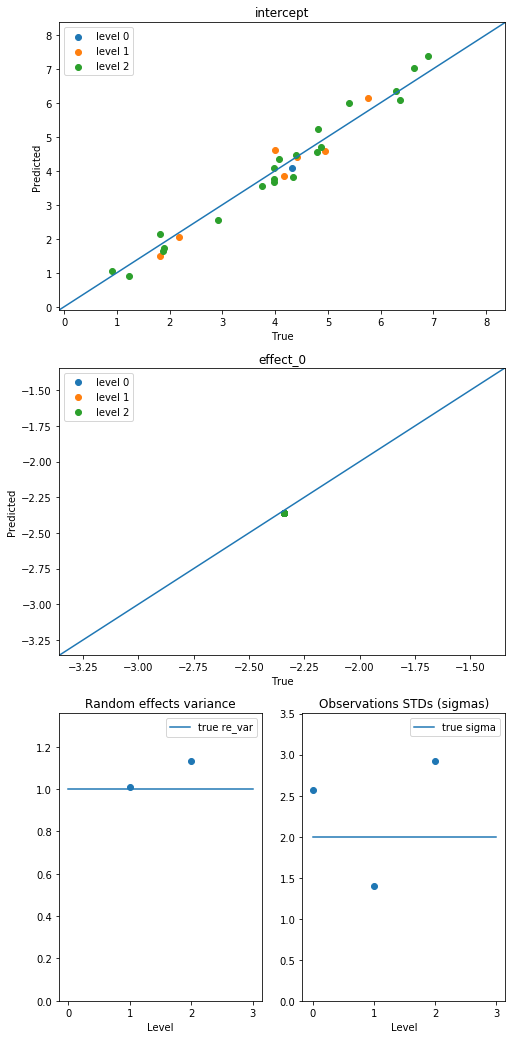

In [10]:
fig = plt.figure(figsize=(8, (2+len(covariates_colnames))*6))
grid = plt.GridSpec(nrows=2+len(covariates_colnames), ncols=2)
levels = sorted(coefficients["level"].unique())
for i in range(len(covariates_colnames)+1):
    covariate_name = "intercept" if i == 0 else f"effect_{i-1}"
    ax = fig.add_subplot(grid[i, :])
    max_coef = -np.infty
    min_coef = np.infty
    for level in levels:
        current_level_coefs = coefficients[coefficients["level"] == level]
        ax.scatter(current_level_coefs[covariate_name+"_true"], current_level_coefs[covariate_name+"_pred"], 
                   label=f"level {level}")
        max_coef = max(max_coef, 
                       current_level_coefs[covariate_name+"_true"].max(), 
                       current_level_coefs[covariate_name+"_pred"].max())
        min_coef = min(min_coef, 
                       current_level_coefs[covariate_name+"_true"].min(), 
                       current_level_coefs[covariate_name+"_pred"].min())
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(covariate_name)
    ax.set_xlim(min_coef-1, max_coef+1)
    ax.set_ylim(min_coef-1, max_coef+1)
    ax.plot([min_coef-1, max_coef+1], [min_coef-1, max_coef+1])
    ax.legend()

gammas_plot = fig.add_subplot(grid[-1, 0])
gammas_plot.scatter(range(1, len(gammas)+1), [gammas[i] for i in levels[1:]])
gammas_plot.plot([0, len(gammas)+1], [true_parameters['re_var'], true_parameters['re_var']], label="true re_var")
#gammas_plot.set_xticklabels([f"level {i}" for i in levels[1:]])
gammas_plot.set_title("Random effects variance")
gammas_plot.set_ylim((0, max([gamma*1.2 for _, gamma in gammas.items()])))
gammas_plot.set_xlabel("Level")
gammas_plot.legend()

sigmas_plot = fig.add_subplot(grid[-1, 1])
sigmas_plot.scatter(range(len(sigmas)), [sigmas[i] for i in levels])
sigmas_plot.plot([0, len(sigmas)], [true_parameters['sigma'], true_parameters['sigma']], label="true sigma")
#sigmas_plot.set_xticklabels([f"level {i}" for i in levels])
sigmas_plot.set_title("Observations STDs (sigmas)")
sigmas_plot.set_ylim((0, max([sigma*1.2 for _, sigma in sigmas.items()])))
sigmas_plot.set_xlabel("Level")
sigmas_plot.legend()

plt.show()

In [11]:
betas

{0: array([ 4.06547556, -2.35906254]),
 1: array([ 3.8719919 , -2.23496784]),
 2: array([ 4.04707631, -2.36007864])}

In [12]:
gammas

{1: array([1.00921357]), 2: array([1.13313538])}

In [13]:
sigmas

{0: 2.570425195296937, 1: 1.4006867917157824, 2: 2.922301829546323}

## Hierarchical Mixed Model 

In [14]:
gammas = {}
sigmas = {}
betas = {}
coefficients = {}

current_level = data["level"] == 0
level0_data = data[current_level][["intercept"] + covariates_colnames].to_numpy()
level0_target = data[current_level]["observation"].to_numpy()
level0_coefficients = lstsq(level0_data, level0_target, rcond=None)[0]
data.loc[current_level, "predictions"] = level0_data.dot(level0_coefficients)
data.loc[current_level, "residues"] = data.loc[current_level, "observation"] - data.loc[current_level, "predictions"]
current_se = np.sqrt((data.loc[current_level, "residues"].var()))
betas[0] = level0_coefficients
sigmas[0] = current_se
coefficients[1] = level0_coefficients # won't work for more than one fixed effect

answers = [{**{
    "location_id": 1,
    "level": 0, 
    "intercept": level0_coefficients[0],
    "group_size": len(level0_data)
}, **{f"effect_{i-1}": level0_coefficients[i] for i in range(1, len(covariates_colnames)+1)} }]

In [15]:
def get_parent_group(group):
    parent_group = data[data["location_id"] == group]["parent_id"].unique()
    assert len(parent_group) == 1
    return parent_group[0]

def get_parent_coefficients(group):
    parent_group = get_parent_group(group)
    v = coefficients.get(parent_group, None)
    assert v is not None
    return v
    

for level in sorted(data["level"].unique())[1:]:
    current_level = data["level"] == level
    data.loc[current_level, "se"] = current_se
    X = data[current_level][covariates_colnames + [ "location_id", "se"]].to_numpy()
    column_labels = [1]*len(covariates_colnames) + [0, 4]
    X = np.vstack([column_labels, X])
    y = data[current_level]["observation"].to_numpy()
    problem = LinearLMEProblem.from_x_y(X, y, random_intercept=True)

    model = LinearLMESparseModel(lb=0,
                                 lg=0, 
                                 nnz_tbeta=len(covariates_colnames)+1, 
                                 nnz_tgamma=1,
                                 tol=1e-7)
    model.fit_problem(problem, initial_parameters={"beta": betas[level-1]})
    
    oracle = LinearLMEOracle(problem)
    current_se = oracle.optimal_obs_std(**model.coef_)
        
    betas[level] = model.coef_["beta"]
    gammas[level] = model.coef_["gamma"] / (level+1) 
    sigmas[level] = current_se
    data.loc[current_level, "se"] = current_se
    
    
    for i, (group, size) in enumerate(zip(problem.group_labels,
                              problem.groups_sizes)):
        v = get_parent_coefficients(group)
        u = oracle.optimal_random_effects(v, gammas[level])
        coefficients[group] = v
        coefficients[group][0] += u[i]
        coefficients[group][1] = betas[level][1]
        answers += [{**{
            "location_id": group,
            "intercept": coefficients[group][0],
            "level": level,
            "group_size": size,
            } , **{
            f"effect_{i-1}": coefficients[group][i] for i in range(1, num_fixed_effects)
            }}]

In [16]:
gammas

{1: array([1.05660541]), 2: array([1.10189901])}

In [17]:
coefficients = pd.DataFrame(answers)
true_coefficients = pd.read_csv(true_coefficients_path)
coefficients = coefficients.merge(true_coefficients, on="location_id", how="inner", suffixes=('_pred', '_true'))
with open(true_parameters_path) as f:
    true_parameters = json.load(f)
coefficients["effect_0_pred"] = level0_coefficients[1]

In [18]:
coefficients[["location_id", "level", "intercept_true", "intercept_pred", "effect_0_true", "effect_0_pred"]]

,location_id,level,intercept_true,intercept_pred,effect_0_true,effect_0_pred
0,1.0,0,4.318642,4.397419,-2.341379,-2.359359
1,4.0,1,2.184258,2.292404,-2.341379,-2.359359
2,31.0,1,3.990685,4.588375,-2.341379,-2.359359
3,64.0,1,4.406185,4.413630,-2.341379,-2.359359
4,103.0,1,5.754598,6.159546,-2.341379,-2.359359
5,137.0,1,4.952157,4.607070,-2.341379,-2.359359
6,158.0,1,4.162084,3.908418,-2.341379,-2.359359
7,166.0,1,1.814906,1.400695,-2.341379,-2.359359
8,5.0,2,1.892655,1.979227,-2.341379,-2.359359
9,9.0,2,1.813178,2.126827,-2.341379,-2.359359


In [19]:
print("Intercept error, effect_0 error ")
print(f"All:    {np.linalg.norm(coefficients['intercept_true'] - coefficients['intercept_pred'])} ", 
      f"{np.linalg.norm(coefficients['effect_0_true'] - coefficients['effect_0_pred'])}")
for level in levels:
    current_level_coefs = coefficients[coefficients["level"]==level]
    print(f"Level {level}: {np.linalg.norm(current_level_coefs['intercept_true'] - current_level_coefs['intercept_pred'])} ", 
      f"{np.linalg.norm(current_level_coefs['effect_0_true'] - current_level_coefs['effect_0_pred'])}")



Intercept error, effect_0 error 
All:    1.6748102706624088  0.09682896137946867
Level 0: 0.07877728746382928  0.01798068672869313
Level 1: 0.9423214225171471  0.04757242548628153
Level 2: 1.3823219300732346  0.08239785798152417


In [20]:
coefficients[["location_id", "intercept_pred", "effect_0_pred"]].to_csv("hhm_hierarchical.csv")

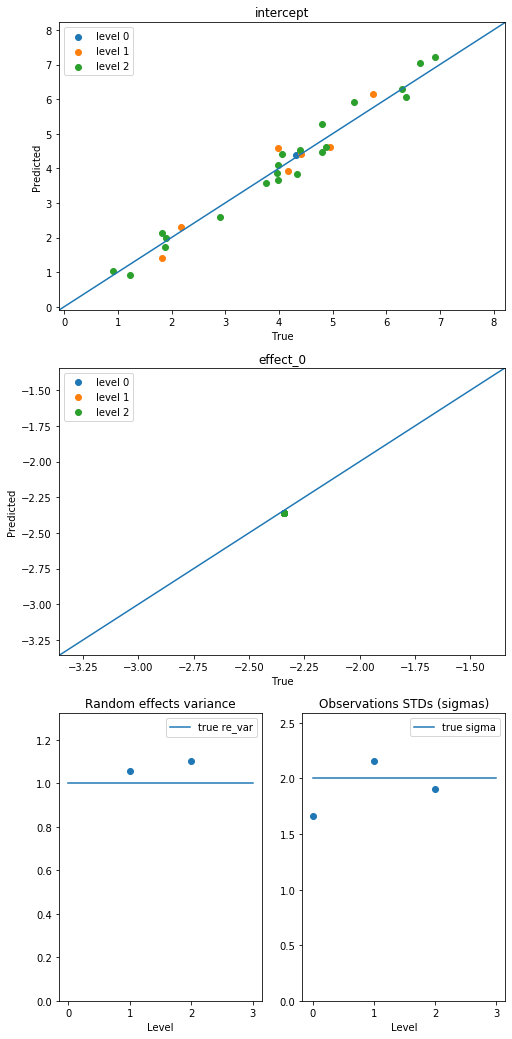

In [21]:
fig = plt.figure(figsize=(8, (2+len(covariates_colnames))*6))
grid = plt.GridSpec(nrows=2+len(covariates_colnames), ncols=2)
levels = sorted(coefficients["level"].unique())
for i in range(len(covariates_colnames)+1):
    covariate_name = "intercept" if i == 0 else f"effect_{i-1}"
    ax = fig.add_subplot(grid[i, :])
    max_coef = -np.infty
    min_coef = np.infty
    for level in levels:
        current_level_coefs = coefficients[coefficients["level"] == level]
        ax.scatter(current_level_coefs[covariate_name+"_true"], current_level_coefs[covariate_name+"_pred"], 
                   label=f"level {level}")
        max_coef = max(max_coef, 
                       current_level_coefs[covariate_name+"_true"].max(), 
                       current_level_coefs[covariate_name+"_pred"].max())
        min_coef = min(min_coef, 
                       current_level_coefs[covariate_name+"_true"].min(), 
                       current_level_coefs[covariate_name+"_pred"].min())
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(covariate_name)
    ax.set_xlim(min_coef-1, max_coef+1)
    ax.set_ylim(min_coef-1, max_coef+1)
    ax.plot([min_coef-1, max_coef+1], [min_coef-1, max_coef+1])
    ax.legend()

gammas_plot = fig.add_subplot(grid[-1, 0])
gammas_plot.scatter(range(1, len(gammas)+1), [gammas[i] for i in levels[1:]])
gammas_plot.plot([0, len(gammas)+1], [true_parameters['re_var'], true_parameters['re_var']], label="true re_var")
#gammas_plot.set_xticklabels([f"level {i}" for i in levels[1:]])
gammas_plot.set_title("Random effects variance")
gammas_plot.set_ylim((0, max([gamma*1.2 for _, gamma in gammas.items()])))
gammas_plot.set_xlabel("Level")
gammas_plot.legend()

sigmas_plot = fig.add_subplot(grid[-1, 1])
sigmas_plot.scatter(range(len(sigmas)), [sigmas[i] for i in levels])
sigmas_plot.plot([0, len(sigmas)], [true_parameters['sigma'], true_parameters['sigma']], label="true sigma")
#sigmas_plot.set_xticklabels([f"level {i}" for i in levels])
sigmas_plot.set_title("Observations STDs (sigmas)")
sigmas_plot.set_ylim((0, max([sigma*1.2 for _, sigma in sigmas.items()])))
sigmas_plot.set_xlabel("Level")
sigmas_plot.legend()

plt.show()

In [22]:
betas

{0: array([ 1.02275144, -2.35935941]),
 1: array([ 3.8534215 , -2.22186494]),
 2: array([ 4.0462878 , -2.35935941])}

In [23]:
gammas

{1: array([1.05660541]), 2: array([1.10189901])}

In [24]:
sigmas

{0: 1.6589440157720068, 1: 2.1576542511397157, 2: 1.9046645691240214}

## Actual Cascade Model

In [94]:
from skmixed.lme.cascades import LMECascade

In [95]:
hierarchy_dict = {row["location_id"]: row["parent_id"] for i, row in hierarchy.iterrows()}

In [96]:
current_level = data["level"] == 0
level0_data = data[current_level][["intercept"] + covariates_colnames].to_numpy()
level0_target = data[current_level]["observation"].to_numpy()
level0_coefficients = lstsq(level0_data, level0_target, rcond=None)[0]
data.loc[current_level, "predictions"] = level0_data.dot(level0_coefficients)
data.loc[current_level, "residues"] = data.loc[current_level, "observation"] - data.loc[current_level, "predictions"]
current_se = np.sqrt((data.loc[current_level, "residues"].var()))

In [97]:
problems = []

for level in levels:
    current_level = data["level"] == level
    data.loc[current_level, "se"] = current_se
    X = data[current_level][covariates_colnames + [ "location_id", "se"]].to_numpy()
    column_labels = [1]*len(covariates_colnames) + [0, 4]
    X = np.vstack([column_labels, X])
    y = data[current_level]["observation"].to_numpy()
    problem = LinearLMEProblem.from_x_y(X, y, random_intercept=True)
    problems.append(problem)

In [98]:
model = LMECascade()
model.fit_problem(problems, hierarchy_dict)
beta = model.coef_["beta"]

In [99]:
answers = [{"location_id": group, "intercept": beta[0] + u[0], "effect_0": beta[1]} for group, u in model.coef_["random_effects"].items()]
coefficients = pd.DataFrame(answers)
true_coefficients = pd.read_csv(true_coefficients_path)
coefficients = coefficients.merge(true_coefficients, on="location_id", how="inner", suffixes=('_pred', '_true'))
coefficients = coefficients.merge(hierarchy[["location_id", "level"]], on="location_id", how="inner")
with open(true_parameters_path) as f:
    true_parameters = json.load(f)

In [100]:
coefficients[["location_id", "level", "intercept_true", "intercept_pred", "effect_0_true", "effect_0_pred"]]

,location_id,level,intercept_true,intercept_pred,effect_0_true,effect_0_pred
0,1.0,0,4.318642,4.364768,-2.341379,-2.328193
1,4.0,1,2.184258,2.557500,-2.341379,-2.328193
2,31.0,1,3.990685,4.459548,-2.341379,-2.328193
3,64.0,1,4.406185,4.535001,-2.341379,-2.328193
4,103.0,1,5.754598,5.936633,-2.341379,-2.328193
5,137.0,1,4.952157,4.768374,-2.341379,-2.328193
6,158.0,1,4.162084,3.635835,-2.341379,-2.328193
7,166.0,1,1.814906,2.208972,-2.341379,-2.328193
8,5.0,2,1.892655,1.810449,-2.341379,-2.328193
9,9.0,2,1.813178,2.053898,-2.341379,-2.328193


In [101]:
print("Intercept error, effect_0 error ")
print(f"All:    {np.linalg.norm(coefficients['intercept_true'] - coefficients['intercept_pred'])} ", 
      f"{np.linalg.norm(coefficients['effect_0_true'] - coefficients['effect_0_pred'])}")
for level in levels:
    current_level_coefs = coefficients[coefficients["level"]==level]
    print(f"Level {level}: {np.linalg.norm(current_level_coefs['intercept_true'] - current_level_coefs['intercept_pred'])} ", 
      f"{np.linalg.norm(current_level_coefs['effect_0_true'] - current_level_coefs['effect_0_pred'])}")

Intercept error, effect_0 error 
All:    1.6117374414683945  0.07100686165205554
Level 0: 0.04612611950439405  0.013185643187369589
Level 1: 0.935346694894658  0.034885932750212977
Level 2: 1.3117532243833792  0.060424207992799926


In [102]:
coefficients[["location_id", "intercept_pred", "effect_0_pred"]].to_csv("cascade.csv")